# Install libs

In [1]:
%%capture
# Transformers installation
! pip install transformers
! pip install datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Getting the Data and Preview it
Below we are going to load the data and show you how to create the splits. However, we don't need to split the data manually becuase I have already created the splits and stored those files seperately which you can quickly download below:

https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp/code


In [2]:
# %%capture 
# !wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
# !wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
# !wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

In [3]:
# with open('train.txt') as f:
#     print(f.read()[:1000])

In [4]:
## export the datasets as txt files
## EXERCISE: Change this to an address

# train_path = "train.txt"
# test_path = "test.txt"
# val_path = "val.txt"

In [5]:
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

--2021-06-11 13:12:45--  https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/607ptdakxuh5i4s/merged_training.pkl [following]
--2021-06-11 13:12:46--  https://www.dropbox.com/s/raw/607ptdakxuh5i4s/merged_training.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaffb13495ed7881e59ab48dd7d.dl.dropboxusercontent.com/cd/0/inline/BQN6AI56GEZLtilHN3qeWdt-cFT1Urkx3CnHQda1cy3i2CUjzS7K25zKhuHMOa4exse1IIedZWaqu_kJBfQEwvIfYNFDVhWlWYRUztfKyP8Ly0dALkdCvsxawR1GTCZJd5uZaNLmTSB5o12o8JNwN0RX/file# [following]
--2021-06-11 13:12:46--  https://ucaffb13495ed7881e59ab48dd7d.dl.dropboxusercontent.com/cd/0/inline/BQN6AI56GEZLtilHN3qeWdt-cFT1Urkx3CnHQda1cy3i2CUjzS7K25zKhuHMOa4exse1I

In [6]:
import pickle

## helper function
def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

(416809, 2)


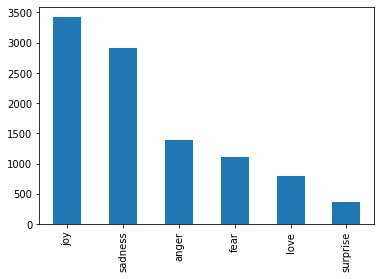

In [7]:
data = load_from_pickle(directory="merged_training.pkl")

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

data = data[data["emotions"].isin(label2int.keys())]

print(data.shape)

data = data.sample(n=10000);

data.emotions.value_counts().plot.bar()

Data has been preprocessed already, using technique from this paper: https://www.aclweb.org/anthology/D18-1404/

In [8]:
data.head()

,text,emotions
111247,i think about the difficult situations and rel...,joy
16170,i feel like im being assaulted by green,fear
42882,i skirt at the office feel dangerous,anger
92968,i suffer from emotional eating and i have been...,sadness
31148,i found myself feeling frustrated,anger


In [9]:
## reset index
data.reset_index(drop=True, inplace=True)

In [10]:
## check unique emotions in the dataset
data.emotions.unique()

array(['joy', 'fear', 'anger', 'sadness', 'love', 'surprise'],
      dtype=object)

## Split the data and store into individual text files

In [11]:
## uncomment the code below to generate the text files for your train, val, and test datasets.

from sklearn.model_selection import train_test_split
import pandas as pd

# Creating training and validation sets using an 80-20 split
input_train, input_val, train_labels, val_labels = train_test_split(data.text.to_list(), 
                                                                    data.emotions.map(label2int).to_numpy(), 
                                                                    # data.emotions.to_numpy(), 
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, val_labels, test_labels = train_test_split(input_val, val_labels, test_size=0.5)


## create a dataframe for each dataset
# train_dataset = pd.DataFrame(data={"text": input_train, "class": train_labels})
# val_dataset = pd.DataFrame(data={"text": input_val, "class": val_labels})
# test_dataset = pd.DataFrame(data={"text": input_test, "class": test_labels})
# final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

# train_dataset.to_csv(train_path, sep=";",header=False, index=False)
# val_dataset.to_csv(test_path, sep=";",header=False, index=False)
# test_dataset.to_csv(val_path, sep=";",header=False, index=False)

## Preparing the datasets

In [12]:
from transformers import AutoTokenizer

# Define the model repo
model_name = "distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [13]:
train_encodings = tokenizer(input_train, truncation=True, padding=True)
val_encodings = tokenizer(input_val, truncation=True, padding=True)
test_encodings = tokenizer(input_test, truncation=True, padding=True)

In [14]:
import torch 
class EmoDataset(torch.utils.data.Dataset):
    # def __init__(self, path):
        # super().__init__()
        # self.data_column = "text"
        # self.class_column = "class"
        # self.data = pd.read_csv(path, sep=";", header=None, 
        #                         names=[self.data_column, self.class_column],
        #                         engine="python")
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels


    # def __getitem__(self, idx):
    #     return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    # def __len__(self):
    #     return self.data.shape[0]
    def __len__(self):
        return len(self.labels)

In [15]:
train_dataset = EmoDataset(train_encodings, train_labels)
val_dataset = EmoDataset(val_encodings, val_labels)
test_dataset = EmoDataset(test_encodings, test_labels)

# Building Custom Classification head on top of LM base model

Use Mish activiation function as in the one proposed in the original tutorial

In [16]:
# # from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
# import torch.nn.functional as F
# from torch import nn
# @torch.jit.script
# def mish(input):
#     return input * torch.tanh(F.softplus(input))
  
# class Mish(nn.Module):
#     def forward(self, input):
#         return mish(input)

The model we will use to do the fine-tuning

In [17]:
# class EmoModel(nn.Module):
#     def __init__(self, base_model, n_classes, 
#                  base_model_output_size=768, dropout=0.05):
#         super().__init__()
#         self.base_model = base_model
        
#         self.classifier = nn.Sequential(
#             nn.Dropout(dropout),
#             nn.Linear(base_model_output_size, base_model_output_size),
#             Mish(),
#             nn.Dropout(dropout),
#             # nn.Linear(base_model_output_size, n_classes)
#             nn.Softmax(n_classes)
#         )
        
#         for layer in self.classifier:
#             if isinstance(layer, nn.Linear):
#                 layer.weight.data.normal_(mean=0.0, std=0.02)
#                 if layer.bias is not None:
#                     layer.bias.data.zero_()

#     def forward(self, input_ids, attention_mask, *args):
#         # print("In Emo")
#         # print("Inputs", type(inputs), len(inputs))
#         # print("Inputs0", type(inputs[0]), "Inputs1", type(inputs[1]))
#         # input_ids, attention_mask = inputs#['input_ids'], inputs['attention_mask']
#         hidden_states = self.base_model(input_ids=input_ids, 
#                                         attention_mask=attention_mask)
#         # maybe do some pooling / RNNs... go crazy here!
        
#         # use the <s> representation
#         return self.classifier(hidden_states[0][:, 0, :])

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

del tokenizer
# del model
# del trainer
torch.cuda.empty_cache()

cuda


In [19]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           num_labels=len(label2int))

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

In [20]:
# emotion_model = EmoModel(base_model=model.base_model, 
#                          n_classes=len(label2int)) 

# Fine-tuning in PyTorch with the Trainer API

Since PyTorch does not provide a training loop, the 🤗 Transformers library provides a `Trainer`
API that is optimized for 🤗 Transformers models, with a wide range of training options and with built-in features like
logging, gradient accumulation, and mixed precision.

First, let's define our model:

This will issue a warning about some of the pretrained weights not being used and some weights being randomly
initialized. That's because we are throwing away the pretraining head of the BERT model to replace it with a
classification head which is randomly initialized. We will fine-tune this model on our task, transferring the knowledge
of the pretrained model to it (which is why doing this is called transfer learning).

In [21]:
# from transformers import TrainerCallback

# class PrinterCallback(TrainerCallback):

#     def on_log(self, args, state, control, logs=None, **kwargs):
#         _ = logs.pop("total_flos", None)
#         if state.is_local_process_zero:
#             print(logs)

which will start a training that you can follow with a progress bar, which should take a couple of minutes to complete
(as long as you hav access to a GPU). It won't actually tell you anything useful about how well (or badly) your model
is performing however as by default, there is no evaluation during training, and we didn't tell the
`Trainer` to compute any metrics. Let's have a look on how to do that now!

To have the `Trainer` compute and report metrics, we need to give it a `compute_metrics`
function that takes predictions and labels (grouped in a namedtuple called `EvalPrediction`) and
return a dictionary with string items (the metric names) and float values (the metric values).

The 🤗 Datasets library provides an easy way to get the common metrics used in NLP with the `load_metric` function.
here we simply use accuracy. Then we define the `compute_metrics` function that just convert logits to predictions
(remember that all 🤗 Transformers models return the logits) and feed them to `compute` method of this metric.

The compute function needs to receive a tuple (with logits and labels) and has to return a dictionary with string keys
(the name of the metric) and float values. It will be called at the end of each evaluation phase on the whole arrays of
predictions/labels.

In [22]:
import numpy as np
from datasets import load_metric
from sklearn.metrics import roc_auc_score

metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metrics_dict = metric.compute(predictions=predictions, references=labels)
    # metrics_dict.update({'roc_auc': roc_auc_score(labels, logits, 
                                                #   average='micro', multi_class='ovr')})
    return metrics_dict

Then, to define our `Trainer`, we will need to instantiate a
`TrainingArguments`. This class contains all the hyperparameters we can tune for the
`Trainer` or the flags to activate the different training options it supports. Let's begin by
using all the defaults, the only thing we then have to provide is a directory in which the checkpoints will be saved:

In [23]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    # model=emotion_model,
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,
)

In [ ]:
trainer_output = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.496600,1.102911,0.571000


In [ ]:
trainer.evaluate()

In [76]:
# from torch.utils.data import DataLoader, Dataset
# class EmoDataset(Dataset):
#     def __init__(self, path):
#         super().__init__()
#         self.data_column = "text"
#         self.class_column = "class"
#         self.data = pd.read_csv(path, sep=";", header=None, 
#                                 names=[self.data_column, self.class_column],
#                                 engine="python")
#         print(path)
#         display(self.data.head(2))

#     def __getitem__(self, idx):
#         return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

#     def __len__(self):
#         return self.data.shape[0]

# import torch

# class TokenizersCollateFn:
#     def __init__(self, tokenizer):
#         self.tokenizer = tokenizer

#     def __call__(self, batch):
#         # encoded = self.tokenizer.encode_batch([x[0] for x in batch])
#         encoded = self.tokenizer([x[0] for x in batch], 
#                    max_length=150, padding=True, truncation=True, 
#                    return_tensors="pt")
        
#         sequences_padded = torch.tensor([enc.ids for enc in encoded])
#         attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
#         labels = torch.tensor([x[1] for x in batch])
        
#         return (sequences_padded, attention_masks_padded), labels
#         # return inputs, labels

Note that if you are used to freezing the body of your pretrained model (like in computer vision) the above may seem a
bit strange, as we are directly fine-tuning the whole model without taking any precaution. It actually works better
this way for Transformers model (so this is not an oversight on our side). If you're not familiar with what "freezing
the body" of the model means, forget you read this paragraph.

Now to check the results, we need to write the evaluation loop. Like in the [trainer section](#trainer) we will
use a metric from the datasets library. Here we accumulate the predictions at each batch before computing the final
result when the loop is finished.

In [ ]:
metric= load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()